### 1.Create Label

In [1]:
import pandas as pd
from pathlib import Path

current_dir = Path.cwd()
df = pd.read_csv(current_dir.parent/ "outputs" /"classification" / "merged_college_stats.csv")
df.head()

,SEASON,OVERALL_PICK,Totals_FG,Totals_FT,Totals_TRB,Totals_BLK,Totals_STL,Totals_TOV,Totals_PF,Shooting_FG%,MP
0,2000,1,221.0,141.0,300.0,107.0,43.0,56.0,71.0,0.568,909.0
1,2000,2,208.0,127.0,279.0,95.0,50.0,80.0,88.0,0.608,1013.0
2,2000,4,327.0,175.0,285.0,39.0,29.0,77.0,103.0,0.582,1243.0
3,2000,5,175.0,124.0,243.0,15.0,46.0,71.0,70.0,0.476,1058.0
4,2000,6,140.0,70.0,123.0,30.0,31.0,46.0,64.0,0.478,879.0


In [2]:
import numpy as np
import pandas as pd

# df is your merged dataset
# drafted = 1 if picked 1–60, undrafted (100) = 0
df["drafted"] = (df["OVERALL_PICK"] <= 60).astype(int)
print(df["drafted"].value_counts())


drafted
1    1210
0     552
Name: count, dtype: int64


### 2. Train Test Split

In [3]:
!pip install imbalanced-learn

You should consider upgrading via the '/Users/tenzin/Desktop/mycodes/nba-draft-ranker/.venv/bin/python3 -m pip install --upgrade pip' command.


In [4]:
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

# ============================
# 1. Train/Test Split by SEASON
# ============================
# Sort all seasons
all_seasons = sorted(df["SEASON"].unique())

# Number of seasons to use as test (20% of 25 = 5)
test_size = 5

# Select last 5 seasons
test_seasons = all_seasons[-test_size:]

# Remaining seasons are the training data
train_seasons = all_seasons[:-test_size]

print("Train seasons:", train_seasons)
print("Test seasons:", test_seasons)

# Create train_df and test_df
train_df = df[df["SEASON"].isin(train_seasons)].copy()
test_df  = df[df["SEASON"].isin(test_seasons)].copy()

print("Train seasons:", sorted(train_df["SEASON"].unique()))
print("Train size:", len(train_df), "Test size:", len(test_df))

# ============================
# 2. Features / Target
# ============================
target_col = "drafted"   # <-- 1 = drafted, 0 = undrafted

feature_cols = [
    "Totals_FG",
    "Totals_FT",
    "Totals_TRB",
    "Totals_STL",
    "Totals_BLK",
    "Totals_TOV",
    "Totals_PF",
    "Shooting_FG%",
    "MP",
]

X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_test  = test_df[feature_cols]
y_test  = test_df[target_col]

print("\nClass balance BEFORE UnderSampling (train):")
print(y_train.value_counts())

# ============================
# 3. UNDER-SAMPLE TRAIN
# ============================
rus_train = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus_train.fit_resample(X_train, y_train)

print("\nClass balance AFTER UnderSampling (train):")
print(pd.Series(y_train_resampled).value_counts())

# ============================
# 4. UNDER-SAMPLE TEST (because you asked)
# ============================

print("\nClass balance BEFORE UnderSampling (test):")
print(y_test.value_counts())

rus_test = RandomUnderSampler(random_state=42)
X_test_resampled, y_test_resampled = rus_test.fit_resample(X_test, y_test)

print("\nClass balance AFTER UnderSampling (test):")
print(pd.Series(y_test_resampled).value_counts())



Train seasons: [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020)]
Test seasons: [np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
Train seasons: [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020)]
Train size: 1430 Test size: 332

Class balance BEFORE UnderSampling (train):
drafted
1    938
0    492
Name: count, dtype: int64

Class balance AFTER UnderSampling (train):
drafted
0    492
1    492
Na

/Users/tenzin/Desktop/mycodes/nba-draft-ranker/.venv/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/tenzin/Desktop/mycodes/nba-draft-ranker/.venv/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/Users/tenzin/Desktop/mycodes/nba-draft-ranker/.venv/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/tenzin/Desktop/mycodes/nba-draft-ranker/.venv/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated i

### 3. Train

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier

numeric_cols = X_train_resampled.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols     = X_train_resampled.select_dtypes(include=["object", "category"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

clf = GradientBoostingClassifier(
    random_state=42
)

model_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", clf),
])


In [6]:
model_clf.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Totals_FG', 'Totals_FT',
                                                   'Totals_TRB', 'Totals_STL',
                                                   'Totals_BLK', 'Totals_TOV',
                                                   'Totals_PF', 'Shooting_FG%',
                                                   'MP']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('clf', GradientBoostingClassifier(random_state=42))])

### 4.Evaluate

Confusion matrix:
 [[37 23]
 [30 30]]

Classification report:

              precision    recall  f1-score   support

           0      0.552     0.617     0.583        60
           1      0.566     0.500     0.531        60

    accuracy                          0.558       120
   macro avg      0.559     0.558     0.557       120
weighted avg      0.559     0.558     0.557       120

ROC-AUC: 0.5397222222222222


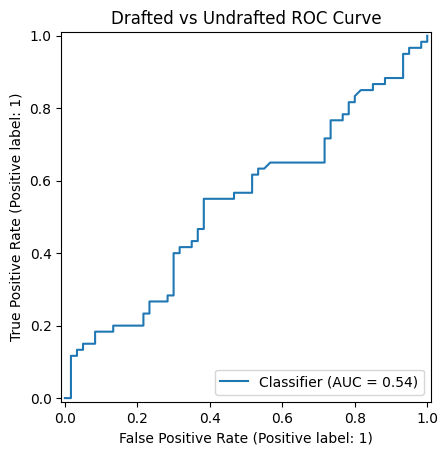

In [8]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    RocCurveDisplay,
)

# Predicted class labels (0/1)
y_pred = model_clf.predict(X_test_resampled)

# Predicted probabilities for class 1 (drafted)
y_proba = model_clf.predict_proba(X_test_resampled)[:, 1]

# Confusion matrix
cm = confusion_matrix(y_test_resampled, y_pred)
print("Confusion matrix:\n", cm)

# Precision / recall / F1 / support
print("\nClassification report:\n")
print(classification_report(y_test_resampled, y_pred, digits=3))

# ROC-AUC
roc_auc = roc_auc_score(y_test_resampled, y_proba)
print("ROC-AUC:", roc_auc)

# Optional: plot ROC curve (if you're in a notebook)
import matplotlib.pyplot as plt

RocCurveDisplay.from_predictions(y_test_resampled, y_proba)
plt.title("Drafted vs Undrafted ROC Curve")
plt.show()


### 6.Optional Tweak

In [10]:
threshold = 0.3  # more players predicted as drafted

y_pred_custom = (y_proba >= threshold).astype(int)

cm_custom = confusion_matrix(y_test_resampled, y_pred_custom)
print("Confusion matrix (threshold=0.3):\n", cm_custom)

print("\nClassification report (threshold=0.3):\n")
print(classification_report(y_test_resampled, y_pred_custom, digits=3))

Confusion matrix (threshold=0.3):
 [[ 9 51]
 [ 8 52]]

Classification report (threshold=0.3):

              precision    recall  f1-score   support

           0      0.529     0.150     0.234        60
           1      0.505     0.867     0.638        60

    accuracy                          0.508       120
   macro avg      0.517     0.508     0.436       120
weighted avg      0.517     0.508     0.436       120

